In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
from sklearn.decomposition import PCA

In [2]:
dataset = "HU"

In [3]:
df_means = pd.read_csv("master/outputs/cluster_means/%s_means.csv"%dataset)
df_emb = pd.read_csv("master/outputs/embeddings/%s_embedding.csv"%dataset)
df_edges = pd.read_csv("master/data/%s_edges.csv"%dataset, index_col="node_1")
df_emb.shape

(47538, 32)

In [4]:
with open('master/outputs/assignments/%s.json'%dataset) as json_file:  
    labels = json.load(json_file)
len(labels)

47538

In [5]:
df_label = pd.DataFrame({"index" : list(labels.keys()), "label" : list(labels.values())})
df_label["index"] = df_label["index"].astype(int)
df_label = df_label.set_index("index")
df_label = df_label.sort_index()
print(df_label.shape)
df_label.head()

(47538, 1)


,label
index,
0,19
1,29
2,31
3,3
4,7


### Diffusion Modeling

In [6]:
from sklearn.metrics.pairwise import cosine_similarity

In [7]:
def cosine(x, y):
    return x.dot(y) / (np.linalg.norm(x) * np.linalg.norm(y))

cosine(df_emb.iloc[1], df_emb.iloc[3])

-0.6559760878970629

In [8]:
def lookup_neighbor(i):
    if i in df_edges.index:
        if len(df_edges.loc[i]) == 1:
            return [df_edges.loc[i].node_2]
        return df_edges.loc[i].node_2
    return []

In [9]:
seeds = [1]

for seed in seeds: 
    neighbors = lookup_neighbor(seed)
    for nei in neighbors:
        print(seed, nei, cosine(df_emb.iloc[seed], df_emb.iloc[nei]))
        print( cosine_similarity(df_emb.iloc[seed].values.reshape(1, -1), df_emb.iloc[nei].values.reshape(1, -1))[0][0])# 

1 5463 0.7248175758314623
0.7248175758314624
1 14232 0.9922557608838273
0.9922557608838272
1 4833 0.9822202697303879
0.9822202697303881
1 36852 0.8673080885352024
0.8673080885352024
1 37620 0.9028622939607568
0.9028622939607567


In [10]:
def simulate_diffusion(seeds, iteration=10):
    df_infected = df_label.copy()
    df_infected.index = df_infected.index.astype(int)
    df_infected["infected"] = False
    df_infected.loc[seeds, 'infected'] = True

    df_history = df_label.copy()
    df_history.index = df_history.index.astype(int)
    prev = len(seeds)
    for i in range(iteration):
        df_infected_cur = df_infected[df_infected.infected==1].index
        for j, source in enumerate(df_infected_cur):
            
            if j % (len(df_emb) // 1000) == 0:
                df_history["i%i_f%i"%(i, j)] = df_infected.infected
            
            neighbors = lookup_neighbor(source)
            neighbors = list(filter(lambda x : cosine(df_emb.iloc[source], df_emb.iloc[x]) > np.random.rand(), neighbors))
            df_infected.loc[neighbors, 'infected'] = True
            
            if j % 1000 == 0:
                print("iteration %i, progress %i/%i, infected %i (%.2f%%)     "
                      %(i, j, len(df_infected_cur), sum(df_infected.infected), 
                        100 * sum(df_infected.infected) / len(np.unique(df_edges.node_2))))
                
    return df_history, df_infected

### Random Seeds

In [11]:
n_seeds = 480

In [12]:
seeds = np.random.choice(df_emb.index, n_seeds)

df_history, df_infected = simulate_diffusion(seeds, iteration=5)

iteration 0, progress 0/477, infected 501 (1.23%)     
iteration 1, progress 0/1900, infected 1903 (4.67%)     
iteration 1, progress 1000/1900, infected 4271 (10.48%)     
iteration 2, progress 0/5028, infected 5029 (12.34%)     
iteration 2, progress 1000/5028, infected 6551 (16.08%)     
iteration 2, progress 2000/5028, infected 7813 (19.17%)     
iteration 2, progress 3000/5028, infected 8536 (20.95%)     
iteration 2, progress 4000/5028, infected 9003 (22.10%)     
iteration 2, progress 5000/5028, infected 9203 (22.59%)     
iteration 3, progress 0/9203, infected 9205 (22.59%)     
iteration 3, progress 1000/9203, infected 9971 (24.47%)     
iteration 3, progress 2000/9203, infected 10774 (26.44%)     
iteration 3, progress 3000/9203, infected 11479 (28.17%)     
iteration 3, progress 4000/9203, infected 11972 (29.38%)     
iteration 3, progress 5000/9203, infected 12373 (30.37%)     
iteration 3, progress 6000/9203, infected 12645 (31.03%)     
iteration 3, progress 7000/9203, in

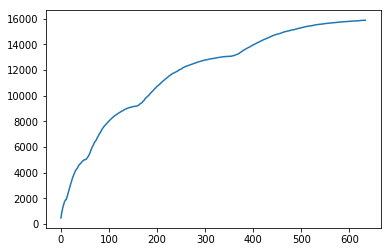

In [13]:
df_sum = df_history.drop(["label"], axis=1).sum(axis=0)
df_sum.to_csv("outputs/%s_sum_random.csv"%dataset, header=True)
plt.plot(df_sum.values)

In [14]:
df_history.iloc[:, :].to_csv("outputs/%s_random.csv"%dataset)

### Influencers

In [15]:
df_influencer = df_edges.groupby("node_1").count()
seeds = df_influencer.sort_values(["node_2"], ascending=False)[:n_seeds].index.values

df_history, df_infected = simulate_diffusion(seeds, iteration=5)

iteration 0, progress 0/480, infected 497 (1.22%)     
iteration 1, progress 0/6691, infected 6691 (16.42%)     
iteration 1, progress 1000/6691, infected 9536 (23.40%)     
iteration 1, progress 2000/6691, infected 11758 (28.86%)     
iteration 1, progress 3000/6691, infected 13397 (32.88%)     
iteration 1, progress 4000/6691, infected 14532 (35.66%)     
iteration 1, progress 5000/6691, infected 15260 (37.45%)     
iteration 1, progress 6000/6691, infected 15764 (38.69%)     
iteration 2, progress 0/15951, infected 15952 (39.15%)     
iteration 2, progress 1000/15951, infected 16702 (40.99%)     
iteration 2, progress 2000/15951, infected 17537 (43.04%)     
iteration 2, progress 3000/15951, infected 18259 (44.81%)     
iteration 2, progress 4000/15951, infected 18952 (46.51%)     
iteration 2, progress 5000/15951, infected 19495 (47.85%)     
iteration 2, progress 6000/15951, infected 19969 (49.01%)     
iteration 2, progress 7000/15951, infected 20392 (50.05%)     
iteration 2, pr

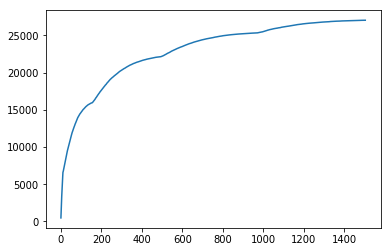

In [16]:
df_sum = df_history.drop(["label"], axis=1).sum(axis=0)
df_sum.to_csv("outputs/%s_sum_influencer.csv"%dataset, header=True)
plt.plot(df_sum.values)

In [17]:
df_history.iloc[:, :].to_csv("outputs/%s_influencer.csv"%dataset)

### Cluster Random Seeds

In [18]:
n_classes = len(np.unique(df_label.label))

In [19]:
for target in range(n_classes):
    print(target, "cluster size", sum(df_label.label==target))

0 cluster size 1382
1 cluster size 1025
2 cluster size 1841
3 cluster size 1885
4 cluster size 1467
5 cluster size 1097
6 cluster size 1496
7 cluster size 2042
8 cluster size 1533
9 cluster size 1422
10 cluster size 1592
11 cluster size 1500
12 cluster size 826
13 cluster size 1382
14 cluster size 1184
15 cluster size 1411
16 cluster size 1951
17 cluster size 1003
18 cluster size 1801
19 cluster size 1554
20 cluster size 1268
21 cluster size 428
22 cluster size 1000
23 cluster size 1914
24 cluster size 1903
25 cluster size 1585
26 cluster size 1976
27 cluster size 1741
28 cluster size 1614
29 cluster size 1494
30 cluster size 1807
31 cluster size 1414


In [20]:
seeds = []
for target in range(n_classes):
    df_cluster = df_label[df_label.label==target]
    cluster_n_seeds = round(n_seeds * len(df_cluster) / len(df_emb))
    seeds += list(np.random.choice(df_cluster.index, cluster_n_seeds, replace=False))

In [21]:
seeds = [int(i) for i in seeds]
len(seeds)

478

In [22]:
df_history, df_infected = simulate_diffusion(seeds, iteration=5)

iteration 0, progress 0/478, infected 490 (1.20%)     
iteration 1, progress 0/1923, infected 1923 (4.72%)     
iteration 1, progress 1000/1923, infected 4256 (10.45%)     
iteration 2, progress 0/5041, infected 5042 (12.37%)     
iteration 2, progress 1000/5041, infected 6478 (15.90%)     
iteration 2, progress 2000/5041, infected 7679 (18.85%)     
iteration 2, progress 3000/5041, infected 8444 (20.72%)     
iteration 2, progress 4000/5041, infected 8932 (21.92%)     
iteration 2, progress 5000/5041, infected 9143 (22.44%)     
iteration 3, progress 0/9145, infected 9145 (22.44%)     
iteration 3, progress 1000/9145, infected 9679 (23.75%)     
iteration 3, progress 2000/9145, infected 10526 (25.83%)     
iteration 3, progress 3000/9145, infected 11191 (27.47%)     
iteration 3, progress 4000/9145, infected 11693 (28.70%)     
iteration 3, progress 5000/9145, infected 12027 (29.52%)     
iteration 3, progress 6000/9145, infected 12282 (30.14%)     
iteration 3, progress 7000/9145, in

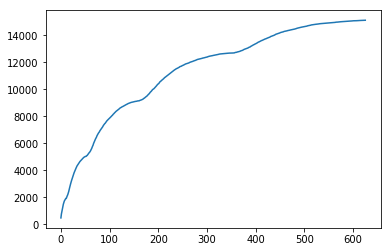

In [23]:
df_sum = df_history.drop(["label"], axis=1).sum(axis=0)
df_sum.to_csv("outputs/%s_sum_cluster_random.csv"%dataset, header=True)
plt.plot(df_sum.values)

In [24]:
df_history.iloc[:, :].to_csv("outputs/%s_cluster_random.csv"%dataset)

#### Cluster Influencer

In [25]:
seeds = []
for target in range(n_classes):
    idxs = df_label[df_label.label == target].index
    df_cluster = df_edges.loc[list(map(int, idxs))]
    
    df_influencer = df_cluster.groupby("node_1").count()
    
    seeds += list(df_influencer.sort_values(["node_2"], ascending=False)[:int(n_seeds / n_classes)].index.values)
len(seeds)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:4: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  after removing the cwd from sys.path.


480

In [26]:
df_history, df_infected = simulate_diffusion(seeds, iteration=5)

iteration 0, progress 0/480, infected 494 (1.21%)     
iteration 1, progress 0/6289, infected 6289 (15.43%)     
iteration 1, progress 1000/6289, infected 9169 (22.50%)     
iteration 1, progress 2000/6289, infected 11557 (28.36%)     
iteration 1, progress 3000/6289, infected 13250 (32.52%)     
iteration 1, progress 4000/6289, infected 14273 (35.03%)     
iteration 1, progress 5000/6289, infected 15019 (36.86%)     
iteration 1, progress 6000/6289, infected 15520 (38.09%)     
iteration 2, progress 0/15614, infected 15615 (38.32%)     
iteration 2, progress 1000/15614, infected 16364 (40.16%)     
iteration 2, progress 2000/15614, infected 17250 (42.34%)     
iteration 2, progress 3000/15614, infected 18065 (44.34%)     
iteration 2, progress 4000/15614, infected 18768 (46.06%)     
iteration 2, progress 5000/15614, infected 19395 (47.60%)     
iteration 2, progress 6000/15614, infected 19929 (48.91%)     
iteration 2, progress 7000/15614, infected 20383 (50.02%)     
iteration 2, pr

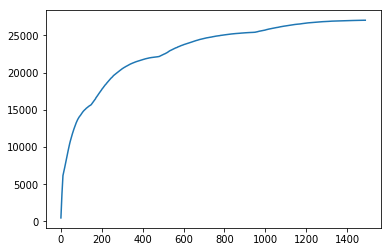

In [27]:
df_sum = df_history.drop(["label"], axis=1).sum(axis=0)
df_sum.to_csv("outputs/%s_sum_cluster_influencer.csv"%dataset, header=True)
plt.plot(df_sum.values)

In [28]:
df_history.iloc[:, :].to_csv("outputs/%s_cluster_influencer.csv"%dataset)

#### Stratified Sampling by Influence

In [32]:
# df_influencer = df_edges.groupby("node_1").count().sort_values(["node_2"], ascending=False)
# df_influencer["influence"] = 100 * df_influencer.node_2 / len(df_label)
# len(df_influencer)

In [33]:
# n_strata = 32
# _ = plt.hist(df_influencer.node_2, bins=n_strata)
# strata_size, strata_bound = _[0], _[1]
# # plt.close()

In [34]:
# strata_sizes = list(map(round, strata_size))
# strata_bounds = list(map(round, strata_bound))

In [35]:
# seeds = []
# for i in range(n_strata):
#     l, r = strata_bounds[i], strata_bounds[i + 1]
#     strata_size = int(strata_sizes[i])
#     df_strata = df_influencer[(df_influencer.node_2 > l) & (df_influencer.node_2 < r)]
#     cluster_n_seeds = round(n_seeds * strata_size / len(df_influencer))
#     cluster_seeds = list(df_strata[:cluster_n_seeds].index.values)
    
#     seeds += cluster_seeds
# print(len(seeds))

In [36]:
# df_history, df_infected = simulate_diffusion(seeds, iteration=5)

In [37]:
# df_sum = df_history.drop(["label"], axis=1).sum(axis=0)
# df_sum.to_csv("outputs/%s_sum_cluster_influencer.csv"%dataset, header=True)
# plt.plot(df_sum.values)